# 2023 Fall AI605 Assignment 3: Information Retrieval

## Rubric

### Deadline

The deadline for this assignment is: Friday 17th November 2023 (Week 12) 11:59pm

### Submission

Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit the Jupyter Notebook file (.ipynb) with all code and model outputs.

Use in-line LaTeX for mathematical expressions.

### Collaboration

This assignment is an individual assingnment. It is **not** a group assignment so make sure your answer and code are your own.

### Grading

The total number of marks avaiable is 25 points. There is a bonus question for +5 marks. If you score >25 points, these marks will be distributed to your other assignments.

### Environment

The use of a GPU is recommended for problem 1.5 and problem 2, limit computation time to approximately 2 hours with a GPU for each task. The suggested environment for this is Python 3.9. Run the following cell to set up the environment.

### Data

Both questions will use a simplified subset of the FEVER dataset. The FEVER dataset is introduced here: https://aclanthology.org/N18-1074/ . For both questions you **MUST USE THE VERSION THAT IS UPLOADED TO KLMS.**

### Libraries

The following libraries should be used for the project. You should not need any other libraries.


In [ ]:
# !pip install torch tqdm datasets transformers

# Problem 1 - Passage Reranking with BERT (12 points)


This question is based on the following paper: "Passage Reranking with BERT" from Rodrigo Nogueira and Kyunghyun Cho: https://arxiv.org/pdf/1901.04085.pdf


**Problem 1.1** (1 point) Describe how the BERT model is utilized for the task of passage re-ranking in the paper. What makes BERT an effective model for this task, as opposed to traditional information retrieval models such as TF-IDF and BM25?


The query is truncated to a maximum of 64 tokens and then input as Sentence A. The text of the passage is similarly truncated to ensure that the combined length of the query, the passage, and any separator tokens does not exceed 512 tokens, and this is input as Sentence B. The `[CLS]` vector is then used as the input for a single-layer neural network, which is used to calculate the probability of the passage's relevance. This probability is computed for each passage independently. Finally, passages are organised into a list based on their respective probabilities, thereby ranking them according to their relevance. The training begins with a pre-trained BERT Large model, which is then specifically adapted to the re-ranking task through the application of cross-entropy loss:

$$
\mathcal{L} = -\sum_{j \in J_\text{pos}} \log (s_j) - \sum_{j \in J_\text{neg}} \log (1 - s_j)
$$

where $J_\text{pos}$ is the set of indexes of the relevant passages, and $J_\text{neg}$ is the set of indexes of non-relevant passages in top-1,000 documents retrieved with BM25.

BERT is an effective model for the task of re-ranking passages because the pre-training on a vast corpus of data gives BERT a broad understanding of language and semantics. This pre-trained knowledge is then fine-tuned for the specific task of passage re-ranking, making it more robust and efficient. It is mentioned in the paper that the pretrained models used in the work required few training examples from the end task to achieve a good performance.


**Problem 1.2** (2 points) The paper employs BERT in a cross-encoder setup for re-ranking. Explain the cross-encoder architecture and how it differs from a bi-encoder architecture (such as DPR) in terms of input format and model inference.


- **Cross-Encoder Architecture**

  The input to a cross-encoder architecture model is a single sequence consisting of both texts (the query and the passage) concatenated together. This sequence typically begins with a special start token (`[CLS]` in BERT), followed by the first text (query), and the second text (passage), separated by a separator token (`[SEP]` in BERT). The cross-encoder processes this concatenated sequence as one. The output of the model is usually derived from the embedding of the start token by feeding the embedding to a classifier FC layer. This architecture can capture the interaction between sentences very effectively. However, it is computationally expensive because the encoding for each pair of sentences must be recomputed, even though they share one sentence.

- **Bi-Encoder Architecture**

  In a bi-encoder architecture model, the query and passage are processed separately. There are two encoder networks in a bi-encoder architecture, and each text is passed through its corresponding encoder, producing independent embeddings for each text. These separate embeddings are then compared to determine the relevance of the passage to the query. This comparison can be as simple as computing the dot product or cosine similarity between the two embeddings. This architecture can capture only a limited amount of interaction between sentences. However, since sentences can be computed and indexed beforehand, it is computationally lightweight. If a sentence is shared between different pairs, the precomputed value can be used instead of recomputing the encoding for every pair.


**Problem 1.3** (1 point) Analyze the computational efficiency of using BERT for passage re-ranking, as discussed in the paper. How does the complexity of the BERT model affect its scalability and usage in a real-world setting?


BERT is a highly complex model with a large number of parameters. Processing each query-passage pair involves a significant amount of computation, particularly because BERT uses a cross-encoder architecture where the query and passage are combined into a single sequence for processing. Thus, using BERT directly for passage re-ranking would not be very optimal because it cannot be scaled to take, for instance, millions of documents. As a cross-encoder architecture requires to process each query-passage _pair_ individually for relevance score computation, the overall efficiency of the architecture would be extremely low, making the architecture difficult to scale to a large number of sentence pairs.

The paper uses BERT as part of a multi-stage method to overcome these difficulties. In the first stage, a more computationally efficient method such as BM25 is used for initial retrieval. This stage narrows down the candidate set from potentially millions of documents to a smaller, more manageable number for the second stage. In the second stage, BERT is used for re-ranking this smaller set of candidates. Although the initial retrieval stage is quick and effective, it may not be as precise or sophisticated in identifying the linkages between the queries and passages. The second stage (re-ranking with BERT) adds this understanding and improves accuracy but is applied only to a limited set of candidates due to its computational cost.


**Problem 1.4** (2 points) Examine the training objective given by equation 1. Describe the role and importance of positive and negative passages in this training objective. How do these contribute to the model's learning process in the context of passage re-ranking?


The training objective is used to train the model to distinguish between relevant and non-relevant passages for a given query. (In my opinion, the objective has some similar aspects to metric learning, where the objective is to increase the distance between embeddings of different classes, while decreasing the distance of the embeddings of the same class, thereby making the class embeddings more 'distinguishable.' Similarly, in this context, the model aims to more effectively distinguish between positive and negative passage instances, i.e., identifying which passages are relevant and which are not.)

Positive passages are examples that are relevant to the query. The model learns from these examples by understanding the patterns, keywords, and contextual signs that signify relevance.

On the other hand, negative passages are not relevant to the query. The model learns from these examples what irrelevance looks like, and how to differentiate between relevant and non-relevant content. Without negative examples, the model might overfit to the positive examples and fail to generalise well to unseen queries and passages. This is critical in passage (re-)ranking scenarios where distinguishing subtle differences in relevance is very important.

The choice of negative passages is important because the properties of the classifier will differ based on the sampling strategy used. One might consider randomly sampling negative passages. The two sequences (the query and the negative passage) in this case would probably be logically and semantically distinct by nature, making the training process quite easy. In this scenario, the decision boundary the model should learn would be simple, but its power would be limited. A different approach would be to deliberately select negative texts for sampling, making the query and the negative passage semantically similar yet irrelevant. (One example professor mentioned in the class is the query being about Louis XIV, and the negative passage being about Louis XV.) The decision boundary in this case is more challenging, and the model would need to pay closer attention to the subtle differences between the positive and negative passages.


**Problem 1.5** (6 points) Using the provided data, implement the passage reranker with BERT paper by fine-tuning the `bert-base-cased` model in HuggingFace and report the MRR@10 on the test set. At test time, you should report MRR using the position of the positive passages considering all the passages (concatenating positive and negative passage lists).

The a simplified version of the FEVER dataset is uploaded to KLMS. The data is provided in JSON lines format where each line in the file is a JSON document. Each element in the training set contains: the query, a list of positive pages, a list of negative passages. A description of the data is provided here: https://aclanthology.org/N18-1074/

Rubric:

- 1 point - tokenization and data preparation
- 2 points - loss function
- 1 point - training loop and appropriate hyperparameters
- 1 point - performing inference for a set of passages
- 1 point - successful convergence and reporting of MRR@10

If you have limited resources, it is acceptable to use a subset of the training data. But still aim to use 1-2 hours of GPU compute for training.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import json
import time
import os
from tqdm import tqdm
import wandb

In [3]:
from collections import defaultdict

num_passages = defaultdict(int)
filepaths = [
    "./fever_data/fever_retrieval_train.jsonl",
    "./fever_data/fever_retrieval_dev.jsonl",
    "./fever_data/fever_retrieval_test.jsonl",
]
names = ["train", "dev", "test"]

for name, path in zip(names, filepaths):
    with open(path) as f:
        for i, line in tqdm(enumerate(f)):
            inst = json.loads(line)

            positive_passages = [
                list(d.values())[0] for d in inst["positive_passages"][0]
            ]
            negative_passages = [
                list(d.values())[0] for d in inst["negative_passages"][0]
            ]

            num_passages[len(positive_passages) + len(negative_passages)] += 1

    print(name)
    print(num_passages)
    print(
        num_passages[max(num_passages, key=num_passages.get)]
        / sum(num_passages.values())
    )
    print()

0it [00:00, ?it/s]

109810it [00:15, 7291.40it/s]


train
defaultdict(<class 'int'>, {10: 100069, 9: 4376, 12: 392, 11: 2607, 3: 38, 8: 1095, 7: 446, 0: 17, 6: 258, 14: 53, 15: 29, 4: 84, 16: 20, 5: 121, 13: 145, 17: 8, 19: 2, 2: 24, 1: 15, 18: 3, 20: 5, 21: 1, 22: 1, 25: 1})
0.911292232037155



6666it [00:00, 7369.88it/s]


dev
defaultdict(<class 'int'>, {10: 105942, 9: 4688, 12: 408, 11: 2869, 3: 39, 8: 1190, 7: 498, 0: 22, 6: 275, 14: 55, 15: 29, 4: 90, 16: 21, 5: 134, 13: 148, 17: 8, 19: 2, 2: 27, 1: 19, 18: 3, 20: 5, 21: 1, 22: 1, 25: 1, 23: 1})
0.9095607678835125



6666it [00:00, 7924.84it/s]

test
defaultdict(<class 'int'>, {10: 111944, 9: 4912, 12: 434, 11: 3130, 3: 43, 8: 1252, 7: 540, 0: 22, 6: 290, 14: 61, 15: 31, 4: 93, 16: 22, 5: 145, 13: 153, 17: 9, 19: 2, 2: 28, 1: 19, 18: 3, 20: 5, 21: 1, 22: 1, 25: 1, 23: 1})
0.9090643322343311



In [4]:
def preprocess_and_save(
    file, tokenizer, save_file_name, query_max_len=64, total_max_len=512
):
    with open(file) as f:
        lines = f.readlines()

    num_queries = len(lines)
    num_passages_per_query = 10

    all_passage_encodings = torch.zeros(
        (num_queries, num_passages_per_query, total_max_len), dtype=torch.int32
    )
    all_labels = torch.zeros((num_queries, num_passages_per_query), dtype=torch.int32)

    for i, line in enumerate(tqdm(lines)):
        inst = json.loads(line)
        query = inst["query"]
        passages = [list(d.values())[0] for d in inst["positive_passages"][0]] + [
            list(d.values())[0] for d in inst["negative_passages"][0]
        ]

        if len(passages) != num_passages_per_query:
            continue

        labels = [1] * len(inst["positive_passages"][0]) + [0] * len(
            inst["negative_passages"][0]
        )

        query_encoding = tokenizer.encode(
            query,
            add_special_tokens=True,
            max_length=query_max_len,
            truncation=True,
        )

        query_len = len(query_encoding)

        for j, passage in enumerate(passages):
            passage_encoding = tokenizer.encode(
                passage,
                add_special_tokens=True,
                max_length=total_max_len - query_len + 1,  # Remove [CLS]
                truncation=True,
                padding="max_length",
            )
            combined_encoding = query_encoding + passage_encoding[1:]
            combined_encoding = torch.tensor(combined_encoding)
            assert len(combined_encoding) == total_max_len

            all_passage_encodings[i, j, : len(combined_encoding)] = combined_encoding
            all_labels[i, j] = labels[j]

    torch.save((all_passage_encodings, all_labels), save_file_name)

    del lines

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [6]:
filepaths = [
    "./fever_data/fever_retrieval_train.jsonl",
    "./fever_data/fever_retrieval_dev.jsonl",
    "./fever_data/fever_retrieval_test.jsonl",
]
names = ["train", "dev", "test"]

for name, path in zip(names, filepaths):
    save_file_name = f"./fever_data/fever_encoded_{name}.pt"
    print(f"Preprocessing {name} data...")
    preprocess_and_save(path, tokenizer, save_file_name)

Preprocessing train data...


100%|██████████| 109810/109810 [24:12<00:00, 75.63it/s]


Preprocessing dev data...


100%|██████████| 6666/6666 [01:22<00:00, 80.88it/s] 


Preprocessing test data...


100%|██████████| 6666/6666 [01:26<00:00, 76.76it/s]


In [2]:
class PassageRerankingDataset(Dataset):
    def __init__(self, file):
        self.encodings, self.labels = torch.load(file)

    def __len__(self):
        return self.encodings.shape[0]

    def __getitem__(self, idx):
        input_ids = self.encodings[idx]  # shape: [10, 512]

        attention_mask = (input_ids != 0).int()  # shape: [10, 512]
        token_type_ids = torch.zeros_like(input_ids)  # shape: [10, 512]
        labels = self.labels[idx]  # shape: [10]

        sep_indices = (input_ids == 102).nonzero(as_tuple=True)

        for i, sep_idx in enumerate(sep_indices[1][::2]):
            token_type_ids[i, sep_idx + 1 :] = 1

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "labels": labels,
        }

In [3]:
train_dataset = PassageRerankingDataset("./fever_data/fever_encoded_train.pt")
test_dataset = PassageRerankingDataset("./fever_data/fever_encoded_test.pt")
val_dataset = PassageRerankingDataset("./fever_data/fever_encoded_dev.pt")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [4]:
class PassageRerankingModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.linear = torch.nn.Linear(768, 1)
        torch.nn.init.kaiming_normal_(self.linear.weight)

        self.criterion = torch.nn.BCEWithLogitsLoss(reduction="sum")

    def forward(self, **kwargs):
        labels = kwargs.pop("labels", None)

        outputs = self.bert(**kwargs)
        pooled_output = outputs[1]
        logits = self.linear(pooled_output)

        loss = self.criterion(logits.squeeze(-1), labels.float())

        return {"loss": loss, "logits": logits}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
model = PassageRerankingModel()
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=3e-6, betas=(0.9, 0.999), weight_decay=0.01
)

using cuda:0


In [ ]:
wandb.init(project="ai605-assignment3")

In [8]:
num_epochs = 5
max_training_time = 5 * 60 * 60  # 5 hours

In [9]:
def evaluate_model(model, val_loader, device):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(val_loader):
            batch = {k: v.squeeze().to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs["loss"]

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

In [10]:
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for train_iter, batch in enumerate(train_loader):
        current_time = time.time()
        if (current_time - start_time) > max_training_time:
            print("Reached maximum training time. Stopping training.")
            break

        batch = {k: v.squeeze().to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs["loss"]
        loss.backward()

        optimizer.step()

        wandb.log({"Training Loss": loss.item()})

        if train_iter % 100 == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Iteration {train_iter}, Training Loss: {loss.item():.4f}"
            )

        if train_iter % 1000 == 0:
            val_loss = evaluate_model(model, val_loader, device)
            wandb.log({"Validation Loss": val_loss})
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Iteration {train_iter}, Validation Loss: {val_loss:.4f}"
            )

    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        f"./bert_reranking_epoch{epoch}.pth",
    )

    if (time.time() - start_time) > max_training_time:
        print("Reached maximum training time. Stopping training.")
        break

Epoch 1/5, Iteration 0, Training Loss: 7.3323
Epoch 1/5, Iteration 0, Validation Loss: 7.2717
Epoch 1/5, Iteration 100, Training Loss: 1.2706
Epoch 1/5, Iteration 200, Training Loss: 1.9903
Epoch 1/5, Iteration 300, Training Loss: 1.9184
Epoch 1/5, Iteration 400, Training Loss: 0.2270
Epoch 1/5, Iteration 500, Training Loss: 0.4033
Epoch 1/5, Iteration 600, Training Loss: 0.6345
Epoch 1/5, Iteration 700, Training Loss: 0.3796
Epoch 1/5, Iteration 800, Training Loss: 0.4182
Epoch 1/5, Iteration 900, Training Loss: 1.0051
Epoch 1/5, Iteration 1000, Training Loss: 2.0050
Epoch 1/5, Iteration 1000, Validation Loss: 0.9970
Epoch 1/5, Iteration 1100, Training Loss: 0.7463
Epoch 1/5, Iteration 1200, Training Loss: 0.7014
Epoch 1/5, Iteration 1300, Training Loss: 3.5718
Epoch 1/5, Iteration 1400, Training Loss: 0.5062
Epoch 1/5, Iteration 1500, Training Loss: 0.3172
Epoch 1/5, Iteration 1600, Training Loss: 1.9304
Epoch 1/5, Iteration 1700, Training Loss: 0.0591
Epoch 1/5, Iteration 1800, Trai

In [23]:
def calculate_mrr_at_10(model, dataset):
    mrr = 0.0
    num_queries = 0

    model.eval()
    for _, data in enumerate(tqdm(dataset)):
        num_queries += 1

        kwargs = {k: v.squeeze().to(device) for k, v in data.items()}
        labels = kwargs["labels"].tolist()

        outputs = model(**kwargs)
        probs = torch.sigmoid(outputs["logits"])
        query_scores = probs.squeeze().tolist()

        ranked_pairs = sorted(
            zip(query_scores, labels), key=lambda x: x[0], reverse=True
        )
        ranked_labels = [label for _, label in ranked_pairs]
        ranks = [i + 1 for i, label in enumerate(ranked_labels) if label == 1]

        if ranks:
            mrr += sum([1.0 / rank for rank in ranks]) / len(ranks)

    return mrr / num_queries

In [24]:
mrr_at_10 = calculate_mrr_at_10(model, test_loader)
print(f"MRR@10: {mrr_at_10}")

100%|██████████| 6666/6666 [18:39<00:00,  5.95it/s] 

MRR@10: 0.5269481412426958


# Problem 2 - Dense Passage Retriever (13 points)

This question is based on the following paper: "Dense Passage Retrieval for Open-Domain Question Answering" from Vladimir Karpukhin et al., https://aclanthology.org/2020.emnlp-main.550/


**Problem 2.1** (1 point) Discuss how the dense passage retrieval approach differs from traditional sparse retrieval methods. Compare the size of the vectors and their sparsity.


- **Sparse Retrieval**

  Sparse retrieval methods such as BM25 represent text as high dimensional sparse vectors. Each dimension corresponds to a specific word in the vocabulary. The vast majority of elements in these vectors are zero, indicating the absence of most words in each specific document or query. The vectors are typically very large (often tens of thousands to millions of dimensions) due to the size of the vocabulary.

- **Dense Retrieval**

  DPR maps text (questions and passages) to lower dimensional continuous space, where each dimension does not correspond to specific individual terms. Instead, these vectors capture semantic meanings and contextual information. Unlike sparse vectors, dense vectors have non-zero values in most dimensions.


**Problem 2.2** (1 point) State the loss function for training the DPR model. The loss function makes use of negative samples, discuss the relationship between the differnt types of negative examples and the overall quality of the retriever model.


The loss function used for training the DPR model is the negative log likelihood of the positive passage:

$$
\mathcal{L}(q_i, p_i^+, p_{i, 1}^-, \cdots, p_{i,n}^-) = -\log \frac{\exp(\text{sim}(q_i, p_i^+))}{\exp(\text{sim}(q_i, p_i^+)) + \sum_{j=1}^n \exp(\text{sim}(q_i, p_{i, j}^-))}
$$

where

$$
\text{sim}(q, p) = E_Q(q)^\top E_P(p)
$$

is the dot product similarity between the question and the passage encodings.

This is also called the '[multi-class N-pair loss](https://papers.nips.cc/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html)', and is a commonly used loss function in terms of deep metric learning. The loss function is optimised to distinguish the positive passage from the negatives. It is formulated to increase the similarity between the embeddings of the question and its relevant passage while decreasing the similarity with the irrelevant passages.

The paper discusses three types of negative examples.

- **Random Negatives**

  Any random passage from the corpus. As discussed in problem 1.4, in this case the decision boundary the model should learn would be simple, but its power would be limited.

- **BM25 Negatives**

  Top passages returned by BM25 that don't contain the answer but match most question tokens. They are useful as they represent a more challenging set of negatives. However, they require additional computational overhead, making it difficult to scale the model for a large dataset.

- **Gold Negatives**

  Positive passages paired with different questions appearing in the training set. They provide a challenging set of negatives while also being computationally efficient.

The best model proposed in the paper uses gold passages from the same mini-batch and one BM25 negative passage. It is mentioned that re-using gold passages from the same batch as negatives can make computation efficient while still achieving great performance.


**Problem 2.3** (1 points) Explain the process of inferring the most relevant passages to a given question using the inner product. What are the computational advantages of this approach during inference? (compare against Problem 1). Include considerations for scalability when dealing with a large corpus.


DPR uses two independent BERT networks as encoders; the representation at the `[CLS]` token is taken as the output. A dense encoder $E_P(\cdot)$ maps any text passage to a 768-dimensional real-valued vectors and builds an index. A different encoder, $E_Q(\cdot)$ maps the input question to a 768-dimensional vector. Then, the inner product (or dot product) is calculated between the vector representation of the question and each passage vector as a metric of similarity. based on these similarity scores, the top $k$-ranked passages are retrieved as the most relevant passages to a given question.

The DPR approach allows for pre-computing and indexing the passage vectors. During inference, only the question needs to be encoded, and its vector is then compared with the pre-computed passage encoding vectors. This is computationally more efficient than encoding both the question and each passage at run-time. For a large corpus, the model can scale to handle very large datasets efficiently, as the expensive computation of passage embeddings is done only once and reused for every query.

In contrast, a cross-encoder architecture as used in Problem 1 computes the relevance of a passage to a question by jointly encoding them, and is computationally more intensive during inference. This is because for each query, it requires the joint encoding of the question with each passage in the corpus, and this needs to be repeated for every new question. This approach is time-consuming and scales poorly with the size of the corpus, making it impractical for large datasets.


**Problem 2.4** (2 points) Using your answer to question 2.3, show how the model can be used for inference to select the top k passages for a given query. Show this using the huggingface `bert-base-cased` model and a sample of 5 instances from the FEVER dataset.


In [25]:
import torch
from transformers import BertTokenizer, BertModel
import json

In [26]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
model_testing = BertModel.from_pretrained("bert-base-cased").to(device)

using cuda:0


In [42]:
model_testing.eval()
with open("./fever_data/fever_retrieval_train.jsonl") as f:
    for i, line in enumerate(f):
        if i > 4:
            break

        inst = json.loads(line)
        query = inst["query"]
        passages = [list(d.values())[0] for d in inst["positive_passages"][0]] + [
            list(d.values())[0] for d in inst["negative_passages"][0]
        ]

        query_encoding = tokenizer.encode(
            query,
            add_special_tokens=True,
            truncation=True,
        )
        passages_encoding = [
            tokenizer.encode(
                passage,
                add_special_tokens=True,
                max_length=512,
                truncation=True,
                padding="max_length",
            )
            for passage in passages
        ]

        query_output = model_testing(
            torch.tensor(query_encoding).unsqueeze(0).to(device)
        )
        passages_output = model_testing(torch.tensor(passages_encoding).to(device))

        inner_product = torch.matmul(query_output[1], passages_output[1].t()).squeeze()
        ranked_passages = torch.argsort(inner_product, descending=True).tolist()

        print(f"Query: {query}")
        print("Top 10 passages:")
        for passage_idx in ranked_passages[:10]:
            print(
                f"{inner_product[passage_idx].item():.4f}: {tokenizer.decode(passages_encoding[passage_idx])}"
            )
        print()

Query: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Top 10 passages:
440.1233: [CLS] CBS - LRB - an initialism of the network's former name, the Columbia Broadcasting System - RRB - is an American English language commercial broadcast television network that is a flagship property of CBS Corporation. The company is headquartered at the CBS Building in New York City with major production facilities and operations in New York City - LRB - at the CBS Broadcast Center - RRB - and Los Angeles - LRB - at CBS Television City and the CBS Studio Center - RRB -. CBS is sometimes referred to as the ` ` Eye Network'', in reference to the company's iconic logo, in use since 1951. It has also been called the ` ` Tiffany Network'', alluding to the perceived high quality of CBS programming during the tenure of William S. Paley. It can also refer to some of CBS's first demonstrations of color television, which were held in a former Tiffany & Co. building in New York City in 1950. The

**Problem 2.5** (8 points) Using the provided FEVER dataset, and extending your answer from 2.4, implement the training loop for DPR by fine-tuning the HuggingFace `bert-base-cased` model. Implement the G+BM25 31+32 setting (see table 3).

- Plot the training and validation loss curves.
- Plot the recall@k curve on the final checkpoint
- To simulate the BM25 negatives, sample a passage from the list of provided negatives from the FEVER file.
- You may have slightly different results as the provided negative passages in the FEVER file are more challenging than BM25.
- There is a bug in reproducing the DPR paper, it may be necessary to perform unit normalization of the BERT embeddings if the exponent of the inner product gets too high: https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html

Rubric:

- Up to 4 points depending on implementation complexity. Computing the loss of a minibatch of strings. If you compute this 1-by-1, only partial credit is possible.
- 2 points for code for loading the data and training the model
- 1 point for convergence of the model and plotting training/validation loss
- 1 point for plotting recall@k on test set


In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import json
import time
from tqdm import tqdm
import wandb

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda:0


In [7]:
def preprocess_and_save(file, tokenizer, save_file_name, total_max_len=512):
    with open(file) as f:
        lines = f.readlines()

    num_queries = len(lines)
    nonempty_passage_count = 0

    all_query_tokens = torch.zeros((num_queries, total_max_len), dtype=torch.int32)
    all_positive_tokens = torch.zeros((num_queries, total_max_len), dtype=torch.int32)
    all_negative_tokens = torch.zeros((num_queries, total_max_len), dtype=torch.int32)

    for line in tqdm(lines):
        inst = json.loads(line)

        try:
            query = inst["query"]
            positive_passage = list(inst["positive_passages"][0][0].values())[0]
            negative_passage = list(inst["negative_passages"][0][0].values())[0]
        except:
            continue

        query_tokens = tokenizer.encode(
            query,
            add_special_tokens=True,
            max_length=total_max_len,
            truncation=True,
            padding="max_length",
        )

        positive_tokens = tokenizer.encode(
            positive_passage,
            add_special_tokens=True,
            max_length=total_max_len,
            truncation=True,
            padding="max_length",
        )
        negative_tokens = tokenizer.encode(
            negative_passage,
            add_special_tokens=True,
            max_length=total_max_len,
            truncation=True,
            padding="max_length",
        )

        all_query_tokens[nonempty_passage_count] = torch.tensor(query_tokens)
        all_positive_tokens[nonempty_passage_count] = torch.tensor(positive_tokens)
        all_negative_tokens[nonempty_passage_count] = torch.tensor(negative_tokens)

        nonempty_passage_count += 1

    del lines

    all_query_tokens = all_query_tokens[:nonempty_passage_count]
    all_positive_tokens = all_positive_tokens[:nonempty_passage_count]
    all_negative_tokens = all_negative_tokens[:nonempty_passage_count]

    assert all_positive_tokens.shape == all_negative_tokens.shape

    torch.save(
        (all_query_tokens, all_positive_tokens, all_negative_tokens),
        save_file_name,
    )

In [8]:
filepaths = [
    "./fever_data/fever_retrieval_train.jsonl",
    "./fever_data/fever_retrieval_dev.jsonl",
    "./fever_data/fever_retrieval_test.jsonl",
]
names = ["train", "dev", "test"]

for name, path in zip(names, filepaths):
    save_file_name = f"./fever_data/fever_dpr_{name}.pt"
    print(f"Preprocessing {name} data...")
    preprocess_and_save(path, tokenizer, save_file_name)

Preprocessing train data...


100%|██████████| 109810/109810 [04:35<00:00, 399.12it/s]


Preprocessing dev data...


100%|██████████| 6666/6666 [00:13<00:00, 503.30it/s]


Preprocessing test data...


100%|██████████| 6666/6666 [00:14<00:00, 467.12it/s]


In [3]:
class DPRDataset(Dataset):
    def __init__(self, file):
        (
            self.query_tokens,
            self.positive_tokens,
            self.negative_tokens,
        ) = torch.load(file)

    def __len__(self):
        return self.query_tokens.shape[0]

    def __getitem__(self, idx):
        query_token = self.query_tokens[idx]
        positive_token = self.positive_tokens[idx]
        negative_token = self.negative_tokens[idx]

        return query_token, positive_token, negative_token

In [13]:
train_dataset = DPRDataset("./fever_data/fever_dpr_train.pt")
test_dataset = DPRDataset("./fever_data/fever_dpr_test.pt")
val_dataset = DPRDataset("./fever_data/fever_dpr_dev.pt")

# I tried training with batch size 32, but this is the maximum that fits in my GPU memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [5]:
class DPRModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model_q = BertModel.from_pretrained("bert-base-cased")
        self.model_p = BertModel.from_pretrained("bert-base-cased")

        self.model_q.to(device)
        self.model_p.to(device)

    def forward(self, query_tokens, passage_tokens):
        """
        query_tokens: [B, 512]
        passage_tokens: [1 + (B-1) + B, 512]
        """
        query_attention_mask = (query_tokens != 0).int()
        passage_attention_mask = (passage_tokens != 0).int()

        query_outputs = self.model_q(query_tokens, attention_mask=query_attention_mask)[
            1
        ]
        passage_outputs = self.model_p(
            passage_tokens, attention_mask=passage_attention_mask
        )[1]

        scores = torch.matmul(query_outputs, passage_outputs.t())  # [32, 64]
        return scores

In [6]:
model = DPRModel()

optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5, betas=(0.9, 0.999), weight_decay=0.01
)


def criterion(scores, targets):
    # I did not use normalisation because the operations used are numerically stable
    softmax_scores = F.log_softmax(scores, dim=-1)

    loss = F.nll_loss(
        softmax_scores,
        targets,
        reduction="mean",
    )

    return loss

In [7]:
num_epochs = 5
max_training_time = 2 * 60 * 60  # 2 hours

In [8]:
def evaluate_model(model, val_loader, device):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(tqdm(val_loader)):
            query_tokens, positive_tokens, negative_tokens = batch
            batch_size = query_tokens.shape[0]

            query_tokens = query_tokens.to(device)
            passage_tokens = torch.cat((positive_tokens, negative_tokens), dim=0).to(
                device
            )
            target_tensor = torch.arange(batch_size).to(device)

            scores = model(query_tokens, passage_tokens)
            total_val_loss += criterion(scores, target_tensor)

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

In [ ]:
wandb.init(project="ai605-assignment3")

In [10]:
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for train_iter, batch in enumerate(train_loader):
        current_time = time.time()
        if (current_time - start_time) > max_training_time:
            break

        query_tokens, positive_tokens, negative_tokens = batch
        batch_size = query_tokens.shape[0]

        query_tokens = query_tokens.to(device)
        passage_tokens = torch.cat((positive_tokens, negative_tokens), dim=0).to(device)
        target_tensor = torch.arange(batch_size).to(device)

        scores = model(query_tokens, passage_tokens)
        loss = criterion(scores, target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"Training Loss": loss})

        if train_iter % 100 == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Iteration {train_iter}, Training Loss: {loss:.4f}"
            )

        if train_iter % 1000 == 0:
            val_loss = evaluate_model(model, val_loader, device)
            wandb.log({"Validation Loss": val_loss})
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Iteration {train_iter}, Validation Loss: {val_loss:.4f}"
            )

    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        f"./dpr_epoch{epoch}.pth",
    )

    if (time.time() - start_time) > max_training_time:
        print("Reached maximum training time. Stopping training.")
        break

Epoch 1/5, Iteration 0, Training Loss: 48.4831


100%|██████████| 514/514 [01:34<00:00,  5.43it/s]


Epoch 1/5, Iteration 0, Validation Loss: 34.1752
Epoch 1/5, Iteration 100, Training Loss: 2.1952
Epoch 1/5, Iteration 200, Training Loss: 1.5538
Epoch 1/5, Iteration 300, Training Loss: 0.3324
Epoch 1/5, Iteration 400, Training Loss: 0.4793
Epoch 1/5, Iteration 500, Training Loss: 0.5454
Epoch 1/5, Iteration 600, Training Loss: 0.4194
Epoch 1/5, Iteration 700, Training Loss: 0.2053
Epoch 1/5, Iteration 800, Training Loss: 0.2283
Epoch 1/5, Iteration 900, Training Loss: 0.1021
Epoch 1/5, Iteration 1000, Training Loss: 0.2228


100%|██████████| 514/514 [01:33<00:00,  5.48it/s]


Epoch 1/5, Iteration 1000, Validation Loss: 0.4663
Epoch 1/5, Iteration 1100, Training Loss: 0.0427
Epoch 1/5, Iteration 1200, Training Loss: 0.0728
Epoch 1/5, Iteration 1300, Training Loss: 0.2026
Epoch 1/5, Iteration 1400, Training Loss: 0.2919
Epoch 1/5, Iteration 1500, Training Loss: 0.0184
Epoch 1/5, Iteration 1600, Training Loss: 0.0274
Epoch 1/5, Iteration 1700, Training Loss: 0.1638
Epoch 1/5, Iteration 1800, Training Loss: 0.9190
Epoch 1/5, Iteration 1900, Training Loss: 0.0315
Epoch 1/5, Iteration 2000, Training Loss: 0.0239


100%|██████████| 514/514 [01:33<00:00,  5.49it/s]


Epoch 1/5, Iteration 2000, Validation Loss: 0.3003
Epoch 1/5, Iteration 2100, Training Loss: 0.0359
Epoch 1/5, Iteration 2200, Training Loss: 0.2498
Epoch 1/5, Iteration 2300, Training Loss: 0.3500
Epoch 1/5, Iteration 2400, Training Loss: 0.0281
Epoch 1/5, Iteration 2500, Training Loss: 0.0205
Epoch 1/5, Iteration 2600, Training Loss: 0.0332
Epoch 1/5, Iteration 2700, Training Loss: 0.6684
Epoch 1/5, Iteration 2800, Training Loss: 0.0181
Epoch 1/5, Iteration 2900, Training Loss: 0.0752
Epoch 1/5, Iteration 3000, Training Loss: 0.1985


100%|██████████| 514/514 [01:33<00:00,  5.49it/s]


Epoch 1/5, Iteration 3000, Validation Loss: 0.3091
Epoch 1/5, Iteration 3100, Training Loss: 0.4103
Epoch 1/5, Iteration 3200, Training Loss: 0.0143
Epoch 1/5, Iteration 3300, Training Loss: 0.0201
Epoch 1/5, Iteration 3400, Training Loss: 0.4588
Epoch 1/5, Iteration 3500, Training Loss: 0.0322
Epoch 1/5, Iteration 3600, Training Loss: 0.0189
Epoch 1/5, Iteration 3700, Training Loss: 0.2488
Epoch 1/5, Iteration 3800, Training Loss: 0.0128
Epoch 1/5, Iteration 3900, Training Loss: 0.0185
Epoch 1/5, Iteration 4000, Training Loss: 0.0310


100%|██████████| 514/514 [01:34<00:00,  5.46it/s]


Epoch 1/5, Iteration 4000, Validation Loss: 0.3994
Epoch 1/5, Iteration 4100, Training Loss: 0.0091
Epoch 1/5, Iteration 4200, Training Loss: 0.0099
Epoch 1/5, Iteration 4300, Training Loss: 0.0659
Epoch 1/5, Iteration 4400, Training Loss: 1.5395
Epoch 1/5, Iteration 4500, Training Loss: 0.0075
Epoch 1/5, Iteration 4600, Training Loss: 0.0832
Epoch 1/5, Iteration 4700, Training Loss: 0.0333
Epoch 1/5, Iteration 4800, Training Loss: 0.0108
Epoch 1/5, Iteration 4900, Training Loss: 0.0576
Epoch 1/5, Iteration 5000, Training Loss: 0.0574


100%|██████████| 514/514 [01:34<00:00,  5.45it/s]


Epoch 1/5, Iteration 5000, Validation Loss: 0.3531
Epoch 1/5, Iteration 5100, Training Loss: 0.0505
Epoch 1/5, Iteration 5200, Training Loss: 0.0062
Epoch 1/5, Iteration 5300, Training Loss: 0.0168
Epoch 1/5, Iteration 5400, Training Loss: 0.0056
Epoch 1/5, Iteration 5500, Training Loss: 0.0230
Epoch 1/5, Iteration 5600, Training Loss: 0.2233
Epoch 1/5, Iteration 5700, Training Loss: 0.2613
Epoch 1/5, Iteration 5800, Training Loss: 0.0129
Epoch 1/5, Iteration 5900, Training Loss: 0.0840
Epoch 1/5, Iteration 6000, Training Loss: 0.0458


100%|██████████| 514/514 [01:34<00:00,  5.47it/s]


Epoch 1/5, Iteration 6000, Validation Loss: 0.3522
Epoch 1/5, Iteration 6100, Training Loss: 0.1734
Epoch 1/5, Iteration 6200, Training Loss: 0.4629
Epoch 1/5, Iteration 6300, Training Loss: 0.0658
Epoch 1/5, Iteration 6400, Training Loss: 0.0510
Epoch 1/5, Iteration 6500, Training Loss: 0.0117
Epoch 1/5, Iteration 6600, Training Loss: 0.9099
Epoch 1/5, Iteration 6700, Training Loss: 0.0323
Epoch 1/5, Iteration 6800, Training Loss: 0.1013
Epoch 1/5, Iteration 6900, Training Loss: 0.0345
Epoch 1/5, Iteration 7000, Training Loss: 0.3895


100%|██████████| 514/514 [01:34<00:00,  5.46it/s]


Epoch 1/5, Iteration 7000, Validation Loss: 0.4599
Epoch 1/5, Iteration 7100, Training Loss: 0.0296
Epoch 1/5, Iteration 7200, Training Loss: 0.0127
Epoch 1/5, Iteration 7300, Training Loss: 0.0025
Epoch 1/5, Iteration 7400, Training Loss: 0.0732
Epoch 1/5, Iteration 7500, Training Loss: 0.0038
Epoch 1/5, Iteration 7600, Training Loss: 0.0515
Epoch 1/5, Iteration 7700, Training Loss: 0.0187
Epoch 1/5, Iteration 7800, Training Loss: 0.0684
Epoch 1/5, Iteration 7900, Training Loss: 0.0343
Epoch 1/5, Iteration 8000, Training Loss: 0.1097


100%|██████████| 514/514 [01:33<00:00,  5.48it/s]


Epoch 1/5, Iteration 8000, Validation Loss: 0.5250
Epoch 1/5, Iteration 8100, Training Loss: 0.2242
Epoch 1/5, Iteration 8200, Training Loss: 0.8390
Epoch 1/5, Iteration 8300, Training Loss: 0.1620
Epoch 1/5, Iteration 8400, Training Loss: 0.2210
Epoch 1/5, Iteration 8500, Training Loss: 0.0258
Epoch 1/5, Iteration 8600, Training Loss: 0.0151
Epoch 1/5, Iteration 8700, Training Loss: 0.0114
Epoch 1/5, Iteration 8800, Training Loss: 0.3716
Epoch 1/5, Iteration 8900, Training Loss: 0.1533
Epoch 1/5, Iteration 9000, Training Loss: 0.1491


100%|██████████| 514/514 [01:34<00:00,  5.47it/s]


Epoch 1/5, Iteration 9000, Validation Loss: 0.5173
Epoch 1/5, Iteration 9100, Training Loss: 0.3991
Epoch 1/5, Iteration 9200, Training Loss: 0.1563
Epoch 1/5, Iteration 9300, Training Loss: 0.1156
Epoch 1/5, Iteration 9400, Training Loss: 0.3608
Epoch 1/5, Iteration 9500, Training Loss: 0.1605
Epoch 1/5, Iteration 9600, Training Loss: 0.0083
Epoch 2/5, Iteration 0, Training Loss: 0.5068


100%|██████████| 514/514 [01:33<00:00,  5.49it/s]


Epoch 2/5, Iteration 0, Validation Loss: 0.7229
Epoch 2/5, Iteration 100, Training Loss: 0.0968
Epoch 2/5, Iteration 200, Training Loss: 0.0211
Epoch 2/5, Iteration 300, Training Loss: 0.0581
Epoch 2/5, Iteration 400, Training Loss: 0.0060
Epoch 2/5, Iteration 500, Training Loss: 0.0117
Epoch 2/5, Iteration 600, Training Loss: 0.0047
Epoch 2/5, Iteration 700, Training Loss: 0.6724
Epoch 2/5, Iteration 800, Training Loss: 0.0476
Epoch 2/5, Iteration 900, Training Loss: 0.0358
Epoch 2/5, Iteration 1000, Training Loss: 0.0980


100%|██████████| 514/514 [01:33<00:00,  5.49it/s]


Epoch 2/5, Iteration 1000, Validation Loss: 0.9969
Epoch 2/5, Iteration 1100, Training Loss: 0.0479
Epoch 2/5, Iteration 1200, Training Loss: 0.0209
Epoch 2/5, Iteration 1300, Training Loss: 0.2255
Epoch 2/5, Iteration 1400, Training Loss: 0.4462
Epoch 2/5, Iteration 1500, Training Loss: 0.7432
Epoch 2/5, Iteration 1600, Training Loss: 0.5625
Epoch 2/5, Iteration 1700, Training Loss: 0.2761
Epoch 2/5, Iteration 1800, Training Loss: 0.0145
Epoch 2/5, Iteration 1900, Training Loss: 0.0112
Epoch 2/5, Iteration 2000, Training Loss: 0.0168


100%|██████████| 514/514 [01:34<00:00,  5.46it/s]


Epoch 2/5, Iteration 2000, Validation Loss: 0.9944
Reached maximum training time. Stopping training.


In [15]:
model_p_trained = model.model_p
model_q_trained = model.model_q

model_p_trained.eval()
model_q_trained.eval()
print("Loaded trained models.")

Loaded trained models.


In [97]:
def precompute_passage_encodings(model_p, passage_tokens):
    passage_attention_mask = (passage_tokens != 0).int()

    with torch.no_grad():
        passage_outputs = model_p(
            passage_tokens, attention_mask=passage_attention_mask
        )[1]

    return passage_outputs

In [98]:
num_passages = len(test_dataset)

all_positive_encodings = torch.zeros((num_passages, 768), dtype=torch.float32)
all_negative_encodings = torch.zeros((num_passages, 768), dtype=torch.float32)

for i, batch in enumerate(tqdm(test_loader)):
    _, positive_tokens, negative_tokens = batch
    curr_batch_size = positive_tokens.shape[0]

    positive_tokens = positive_tokens.to(device)
    negative_tokens = negative_tokens.to(device)

    positive_encodings = precompute_passage_encodings(model_p_trained, positive_tokens)
    negative_encodings = precompute_passage_encodings(model_p_trained, negative_tokens)

    all_positive_encodings[i * 32 : i * 32 + curr_batch_size] = positive_encodings
    all_negative_encodings[i * 32 : i * 32 + curr_batch_size] = negative_encodings

  0%|          | 0/136 [00:00<?, ?it/s]

100%|██████████| 136/136 [01:03<00:00,  2.14it/s]


In [99]:
all_passage_encodings = torch.cat(
    (all_positive_encodings, all_negative_encodings), dim=0
)
all_passage_encodings = all_passage_encodings.to(device)
print(all_passage_encodings.shape)

torch.Size([8664, 768])


In [100]:
def calculate_recall_at_k(model_q, test_loader, test_passage_encodings, k_values):
    recall_scores = {k: 0 for k in k_values}

    model_q.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader)):
            query_tokens, _, _ = batch
            curr_batch_size = query_tokens.shape[0]

            query_tokens = query_tokens.to(device)
            query_attention_mask = (query_tokens != 0).int()
            query_encodings = model_q(
                query_tokens, attention_mask=query_attention_mask
            )[1]

            scores = torch.matmul(
                query_encodings, test_passage_encodings.t()
            )  # shape: [32, M]
            ranks = torch.argsort(scores, descending=True, dim=1) + 1
            curr_batch_portion = ranks[:, i * 32 : i * 32 + curr_batch_size]
            correct_ranks = torch.diagonal(curr_batch_portion)
            assert correct_ranks.shape[0] == curr_batch_size

            for k in k_values:
                recall_scores[k] += torch.sum(correct_ranks <= k).item()

    average_recall = {k: recall_scores[k] / len(test_dataset) for k in k_values}
    return average_recall

In [110]:
k_values = [500, 1000, 2000, 4000]
recall_at_k = calculate_recall_at_k(
    model_q_trained, test_loader, all_passage_encodings, k_values
)

100%|██████████| 136/136 [00:31<00:00,  4.36it/s]


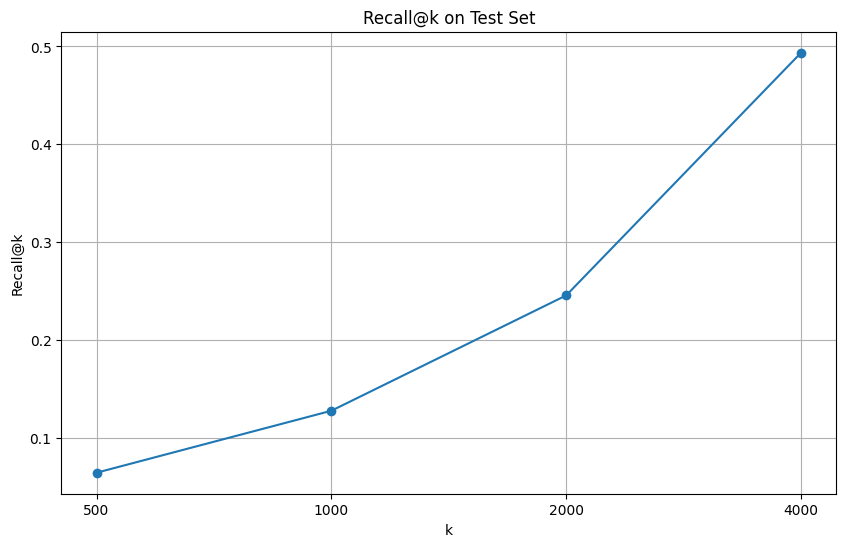

In [111]:
import matplotlib.pyplot as plt

k_list = list(recall_at_k.keys())
recall_list = list(recall_at_k.values())

k_categories = [str(k) for k in k_list]
x_positions = range(len(k_categories))

plt.figure(figsize=(10, 6))
plt.plot(x_positions, recall_list, marker="o")
plt.xticks(x_positions, k_categories)
plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Recall@k on Test Set")
plt.grid(True)
plt.show()

# Bonus Problem - "KAIST Questions for Questions Scheme" (5 bonus points)

“Questions for Questions” has been implemented to foster talent capable of asking questions and to shape the QAIST DNA, in line with the QAIST New Culture Strategy. Instructors allow students to create their own questions for examinations. By enhancing students’ ability to independently think and question, the university seeks to develop a culture of nurturing creative talent.

“문제내는 문제”는 QAIST 신문화전략 중 질문하는 인재! QAIST DNA 형성을 위한 실천 방안으로 매학기 개설되는 정규수업에서 강의교원이 답 없는 문제를 출제하거나,
학생 스스로가 직접 문제를 출제하도록 하는 시험 방식입니다. 이를 통해 학생 스스로 사고하고 질문하는 역량을 키워줌으로써 창의 인재를 양성하는 문화로 확산해 나가고자 합니다.

## Instructions

Please formulate one question (and include a sample answer/rubric) that you would propose for an NLP exam. A selection of high quality questions will be featured in the 4th assignment as an additional bonus question.

Your question should ideally pertain to topics discussed in the recommended readings, lecture slides, or practical exercises. It is suggested that you base your question on a topic where you previously lost marks in the first three assignments. This will not only provide an opportunity for you to deepen your understanding of the subject but also assist your peers in revisiting these essential concepts.

Tips for Making your Question:

- Relevance: Ensure the question is tightly aligned with course content and objectives.
- Clarity: Formulate your question clearly and unambiguously.
- Depth: Aim for a question that tests more than just factual recall – include application, analysis, or evaluation.
- Innovative Thinking: Try to introduce a new perspective or a unique problem-solving approach.
- Constructive Learning: Focus on areas that can enhance understanding of complex topics or correct common misconceptions.

### Judging criteria:

Please follow the following criteria

- True/False, Multiple Choice, or Simple Bookwork questions will not be accepted.
- The question must be directly related to topics covered in the readings, lectures, or exercises, or be applications of the course material.
- The question can be complex book work, connecting difffernt topics, coding or math based
- It should reflect important concepts or skills that are fundamental to the course.
- The question should be clearly phrased and unambiguous.
- The sample answer / rubric should be correct.
- It must be structured logically, allowing students to understand what is being asked without confusion.

The following grading rubric will be applied

- **Depth and Complexity**

  - The question should challenge students to think critically or apply concepts in a novel way.
  - Higher points for questions that require synthesis of multiple concepts or analysis of scenarios.
  - If this question relates to where you lost marks in the first 2 assignments, the complexity score will be easier to attain

- **Originality and Creativity**

  - The question should offer a fresh perspective or tackle a common topic in an innovative way.
  - It should stand out from standard textbook questions or those commonly found in exams.

- **Practical Application or Implication**

  - Questions that connect theory to real-world applications or current research trends score higher.
  - The question should prompt students to think about the practical implications or future directions of the topic.

- **Correctness**
  - The sample answer should be correct to attain the grade


**Question 1**: When implementing the softmax function in machine learning models, one can encounter specific problematic scenarios. What are the problems that arises with softmax, particularly related to numerical stability? Additionally, how would you address this issue to ensure the stable operation of the softmax function?


One of the main issues with the softmax function is numerical instability, especially when dealing with very large or very small numbers. This is because softmax involves exponentiation, which can lead to extremely large values for big input numbers, causing an overflow (or very small values for small input numbers, leading to underflow). Both situations can result in numerical errors or imprecise calculations.

To address this, a common technique is to use the "softmax stabilisation" method. This involves subtracting the maximum value in the input vector from each element of the vector before applying the exponentiation:

$$
\text{softmax}(x_i) = \frac{e^{x_i - M}}{\sum_j e^{x_j - M}}, \text{ where } M = \max_i{x_i}
$$

This does not affect the output of the softmax function, as it gets canceled out in the normalization step. It also significantly reduces the chances of encountering overflow or underflow problems. This technique ensures more numerically stable computations without altering the softmax function's output.


**Question 2**: Recall the objective function used in DPR. How could you modify this objective function to introduce a control mechanism for the penalty applied to hard negatives? (A hard negative is defined as a non-relevant passage that is similar enough to a query to be mistaken as relevant.) How would this modification impact the training and performance of the DPR model?


To introduce a control mechanism for the penalty applied to hard negatives, we can implement a temperature hyperparameter in the softmax function used in the DPR's objective function. The temperature parameter, typically denoted as $\tau$, adjusts the softmax function's concentration level, allowing the model to be more or less sensitive to hard negatives.

By modifying the softmax function in the DPR objective function as follows, we can control the penalty on hard negatives:

$$
\mathcal{L}(q_i, p_i^+, p_{i, 1}^-, \cdots, p_{i,n}^-) = -\log \frac{\exp(\text{sim}(q_i, p_i^+) / \tau)}{\exp(\text{sim}(q_i, p_i^+) / \tau) + \sum_{j=1}^n \exp(\text{sim}(q_i, p_{i, j}^-) / \tau)}
$$

A higher temperature makes the softmax function smoother, thereby reducing the penalty on hard negatives. Conversely, a lower temperature sharpens the softmax function, increasing the penalty on hard negatives.

Incorporating this temperature hyperparameter allows for more nuanced training of the DPR model. It enables the fine-tuning of the model's sensitivity to hard negatives, potentially improving the discrimination between relevant and non-relevant passages and enhancing overall retrieval performance. However, the optimal temperature value may vary depending on the specific dataset and needs to be empirically determined.

Reference: [Wang, F., & Liu, H. (2021). Understanding the behaviour of contrastive loss. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 2495-2504).](https://openaccess.thecvf.com/content/CVPR2021/html/Wang_Understanding_the_Behaviour_of_Contrastive_Loss_CVPR_2021_paper.html)
